Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	train's rmse: 1.09275e+06	eval's rmse: 353544
MAE: 296878.0180, RMSE: 353543.6153, R2: -0.0283


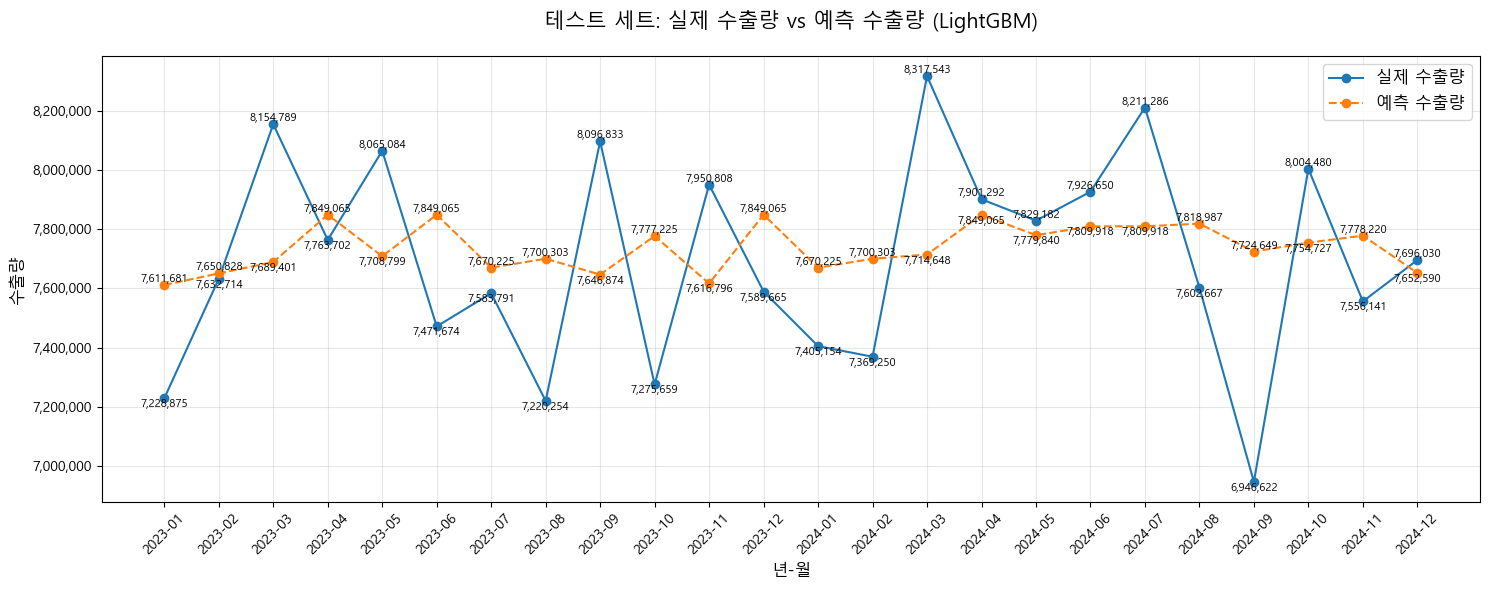


실제값과 예측값 비교 (LightGBM):
             실제 수출량   예측 수출량
date                        
2023-01-01  7228875  7611681
2023-02-01  7632714  7650828
2023-03-01  8154789  7689401
2023-04-01  7763702  7849065
2023-05-01  8065084  7708799
2023-06-01  7471674  7849065
2023-07-01  7583791  7670225
2023-08-01  7220254  7700303
2023-09-01  8096833  7646874
2023-10-01  7275659  7777225
2023-11-01  7950808  7616796
2023-12-01  7589665  7849065
2024-01-01  7405154  7670225
2024-02-01  7369250  7700303
2024-03-01  8317543  7714648
2024-04-01  7901292  7849065
2024-05-01  7829182  7779840
2024-06-01  7926650  7809918
2024-07-01  8211286  7809918
2024-08-01  7602667  7818987
2024-09-01  6946622  7724649
2024-10-01  8004480  7754727
2024-11-01  7556141  7778220
2024-12-01  7696030  7652590


In [7]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('data_integ.csv', parse_dates=['date'])  # 데이터 통합본 넣기 // 감성지수 데이터도 포함
df.set_index('date', inplace=True)

# Lag 및 파생변수 생성
# 이전 수출량 데이터를 반영해 시계열의 연속성과 패턴을 학습하도록 lag 및 파생 변수 생성
df['lag_1'] = df['export_restored'].shift(1) # 한 달 전 수출량
df['lag_2'] = df['export_restored'].shift(2) # 두 달 전 수출량
df['rolling_3'] = df['export_restored'].rolling(window=3).mean().shift(1) # 이전 3개월간 수출량 평균 (직전 월까지)
df['diff_1'] = df['export_restored'].diff(1).shift(1) # 직전 월 대비 수출량 차이 (변동성 반영)

# 타겟 변수와 피쳐 분리
X = df.drop(columns=['export_restored', 'export'])
y = df['export_restored']

# 학습/테스트 데이터 분할 (80:20) (시계열 순서 유지)
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# LightGBM 데이터셋 변환
dtrain = lgb.Dataset(data=X_train, label=y_train)
dtest = lgb.Dataset(data=X_test, label=y_test)

# 모델 파라미터 설정
params = {
    'max_depth': 3,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate' : 0.1,
    'verbose' : -1
}
num_rounds = 300

# early_stopping을 위한 callback 설정
callbacks = [lgb.early_stopping(stopping_rounds=30)]

# LightGBM 모델 학습
model = lgb.train(params, dtrain, num_boost_round=num_rounds,
                  valid_sets=[dtrain, dtest],
                  valid_names=['train', 'eval'], # 각각의 데이터셋 이름 지정
                  callbacks=callbacks)  # early stopping 설정

# 예측 수행
preds = model.predict(X_test, num_iteration=model.best_iteration)

# 모델 성능 평가
def get_reg_eval(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

get_reg_eval(y_test, preds)

# ---------------------- 여기서부터는 시각화 코드 ----------------------------
# 예측 결과와 실제 값을 포함한 DataFrame 생성 
results_df = pd.DataFrame({
    '실제 수출량': y_test,
    '예측 수출량': preds
})

# 소수점 반올림 및 정수형 변환
results_df = results_df.round(0).astype(int)

# x축 눈금용 날짜 리스트 생성
dates = results_df.index.strftime('%Y-%m')

# 실제값과 예측값 시각화
plt.figure(figsize=(15, 6))

plt.plot(range(len(dates)), results_df['실제 수출량'], 
         marker='o', linestyle='-', label='실제 수출량', color='#1f77b4')
plt.plot(range(len(dates)), results_df['예측 수출량'], 
         marker='o', linestyle='--', label='예측 수출량', color='#ff7f0e')

# 실제값과 예측값 텍스트 표시 (겹치지 않게)
for i in range(len(dates)):
    real_val = results_df['실제 수출량'].iloc[i]
    pred_val = results_df['예측 수출량'].iloc[i]
    
    if real_val >= pred_val:
        plt.text(i, real_val, f'{real_val:,.0f}', 
                 verticalalignment='bottom', 
                 horizontalalignment='center',
                 fontsize=8)
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                 verticalalignment='top', 
                 horizontalalignment='center',
                 fontsize=8)
    else:
        plt.text(i, pred_val, f'{pred_val:,.0f}', 
                 verticalalignment='bottom', 
                 horizontalalignment='center',
                 fontsize=8)
        plt.text(i, real_val, f'{real_val:,.0f}', 
                 verticalalignment='top', 
                 horizontalalignment='center',
                 fontsize=8)

# 그래프 스타일링
plt.title('테스트 세트: 실제 수출량 vs 예측 수출량 (LightGBM)', fontsize=15, pad=20)
plt.xlabel('년-월', fontsize=12)
plt.ylabel('수출량', fontsize=12)
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)

# x축 설정
plt.xticks(range(len(dates)), dates, rotation=45)

# y축 포맷팅 (천 단위 쉼표)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

plt.tight_layout()
plt.show()

# 결과 출력 (선택 사항)
print("\n실제값과 예측값 비교 (LightGBM):")
print(results_df.to_string(float_format=lambda x: '{:,.0f}'.format(x)))


# 피처 중요도 시각화
# xgb.plot_importance(model, importance_type='weight', height=0.5)
# plt.title('XGBoost Feature Importance')
# plt.tight_layout()
# plt.show()